In [1]:
import datetime
from inspect import getmembers, isfunction

import numpy as np
import windrose
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import gusi_wrf
import gusi_utils

# Paths and configuratios

In [2]:
plotdir = 'img/'
datos = '../../Datos/'

In [3]:
date_bgn = datetime.datetime(2018,1,1,0)
date_end = datetime.datetime(2018,12,31,23)

# Analysis

In [4]:
title = 'Northwest'
nombre = 'LaRumorosa'

obs_title = 'Measurements'
sim_title = 'WRF'
ws_max = 28

In [5]:
#Read WRF csv and create dataframe

df_wrf = pd.read_csv(datos+'WRF/'+nombre+'_WRF_80m.csv',index_col='Date',parse_dates=True)
df_wrf.index = df_wrf.index - pd.DateOffset(hours=5)        #Pasar WRF a hora local
df_wrf = df_wrf.loc[date_bgn : date_end]

In [6]:
#Read WAM

df_wam = pd.read_csv(datos+'Observaciones/AEM/'+nombre+'_AEM.csv',index_col='Date',parse_dates=True)
df_wam = df_wam.resample('1H').mean()
df_wam.index = df_wam.index + pd.DateOffset(hours=1)
df_wam = df_wam.loc[date_bgn : date_end]

In [7]:
#Join dataframe
df = df_wrf.join(df_wam)
df.rename(columns = {'Wind speed':'WRF-80m','WS_80mA_mean':'WAM-80m','Wind from direction':'WRF-direction','WD_78m_mean':'WAM-direction'}, inplace=True)

df_ws = df[['WRF-80m', 'WAM-80m']]
df_wd = df[['WRF-direction', 'WAM-direction']]

### Time Series

Text(0.5, 1.0, 'Northwest')

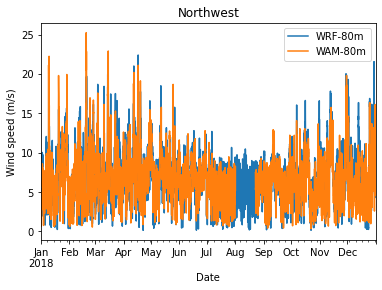

In [8]:
ts = df_ws.plot(ylabel='Wind speed (m/s)')
plt.title(title)
#plt.savefig(plotdir+'/ts_'+title+'.pdf',format='pdf',bbox_inches='tight')

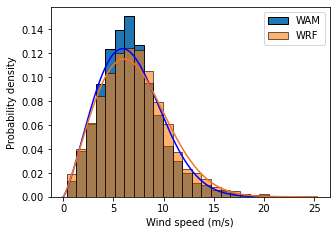

In [9]:
WAM_80m, WRF_80m = gusi_utils.ignore_nan(df_ws['WAM-80m'],df_ws['WRF-80m'])
WAM_80m_wd, WRF_80m_wd = gusi_utils.ignore_nan(df_wd['WAM-direction'],df_wd['WRF-direction'])


xmin = 0
xmax = max(np.max(WAM_80m),np.max(WRF_80m))
ws_vect = np.linspace(xmin, xmax, len(WAM_80m))

param_wam = scipy.stats.weibull_min.fit(WAM_80m, floc=0)
pdf_wam = scipy.stats.weibull_min.pdf(ws_vect,param_wam[0],param_wam[1],param_wam[2])

param_wrf = scipy.stats.weibull_min.fit(WRF_80m, floc=0)
pdf_wrf = scipy.stats.weibull_min.pdf(ws_vect,param_wrf[0],param_wrf[1],param_wrf[2])

fig, ax = plt.subplots(figsize=(5,3.5))

n, bins, patches = plt.hist(WAM_80m,bins=26,density=True, edgecolor = 'black', label='WAM')
plt.hist(WRF_80m,bins=bins, density=True, edgecolor = 'black', alpha=0.6, label='WRF')

plt.plot(ws_vect, pdf_wam, color='blue')
plt.plot(ws_vect, pdf_wrf, color='#F37329')

plt.legend()
plt.xlabel("Wind speed (m/s)")
plt.ylabel("Probability density")

plt.savefig(plotdir+'hist_'+title+'.pdf',format='pdf',bbox_inches='tight')

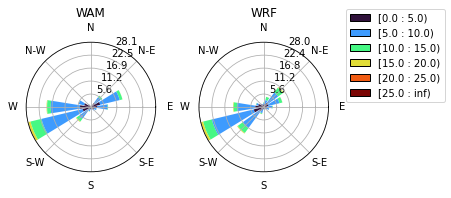

In [10]:
fig=plt.figure(figsize=(6,4.5))


rect1 = [0.1, 0, 0.4, 0.4]
ax = windrose.WindroseAxes(fig, rect1)
fig.add_axes(ax)
#ax.tick_params(labelsize=15)
ax.bar(WAM_80m_wd,WAM_80m,normed=True,nsector=16,opening=0.8,bins=np.arange(0, 30, 5), cmap=cm.turbo)
#ax.grid(linestyle='--',color='silver',which='both')
#ax.set_rlabel_position(-45)
ax.set_title('WAM')

rect=[0.5,0,0.4,0.4]
ax1 = windrose.WindroseAxes(fig, rect)
fig.add_axes(ax1)
ax1.bar(WRF_80m_wd,WRF_80m,normed=True,nsector=16,opening=0.8,bins=np.arange(0, 30, 5), cmap=cm.turbo)
ax1.legend(fontsize=10,bbox_to_anchor=(1.1,0.5))
ax1.legend(bbox_to_anchor=(1.1,0.5))
ax1.set_title('WRF')

plt.savefig(plotdir+'roses_'+title+'.pdf',format='pdf',bbox_inches='tight')

### Statistic metrics

In [11]:
from scipy import stats
import sklearn.metrics
import numpy as np

#Hourly
r_h = stats.pearsonr(WRF_80m,WAM_80m)[0]
mae_h = sklearn.metrics.mean_absolute_error(WRF_80m,WAM_80m)
ae_std_h = np.abs(WRF_80m-WAM_80m).std()
bias_h = np.sum((WRF_80m-WAM_80m)/len(WAM_80m))
rmse_h = sklearn.metrics.mean_squared_error(WAM_80m, WRF_80m,squared=False)
mape_h = sklearn.metrics.mean_absolute_percentage_error(WAM_80m, WRF_80m)*100
print(mape_h)
#3Hourly
WRF_80m_3h = WRF_80m.resample('3H').mean()
WAM_80m_3h = WAM_80m.resample('3H').mean()
WAM_80m_3h, WRF_80m_3h = gusi_utils.ignore_nan(WAM_80m_3h,WRF_80m_3h)
r_3h = stats.pearsonr(WRF_80m_3h,WAM_80m_3h)[0]
mae_3h = sklearn.metrics.mean_absolute_error(WRF_80m_3h,WAM_80m_3h)
ae_std_3h = np.abs(WRF_80m_3h-WAM_80m_3h).std()
bias_3h = np.sum((WRF_80m_3h-WAM_80m_3h)/len(WAM_80m_3h))
rmse_3h = sklearn.metrics.mean_squared_error(WAM_80m_3h, WRF_80m_3h,squared=False)

#6Hourly
WRF_80m_6h = WRF_80m.resample('6H').mean()
WAM_80m_6h = WAM_80m.resample('6H').mean()
WAM_80m_6h, WRF_80m_6h = gusi_utils.ignore_nan(WAM_80m_6h,WRF_80m_6h)
r_6h = stats.pearsonr(WRF_80m_6h,WAM_80m_6h)[0]
mae_6h = sklearn.metrics.mean_absolute_error(WRF_80m_6h,WAM_80m_6h)
ae_std_6h = np.abs(WRF_80m_6h-WAM_80m_6h).std()
bias_6h = np.sum((WRF_80m_6h-WAM_80m_6h)/len(WAM_80m_6h))
rmse_6h = sklearn.metrics.mean_squared_error(WAM_80m_6h, WRF_80m_6h,squared=False)

#12Hourly
WRF_80m_12h = WRF_80m.resample('12H').mean()
WAM_80m_12h = WAM_80m.resample('12H').mean()
WAM_80m_12h, WRF_80m_12h = gusi_utils.ignore_nan(WAM_80m_12h,WRF_80m_12h)
r_12h = stats.pearsonr(WRF_80m_12h,WAM_80m_12h)[0]
mae_12h = sklearn.metrics.mean_absolute_error(WRF_80m_12h,WAM_80m_12h)
ae_std_12h = np.abs(WRF_80m_12h-WAM_80m_12h).std()
bias_12h = np.sum((WRF_80m_12h-WAM_80m_12h)/len(WAM_80m_12h))
rmse_12h = sklearn.metrics.mean_squared_error(WAM_80m_12h, WRF_80m_12h,squared=False)

#Daily
WRF_80m_d = WRF_80m.resample('D').mean()
WAM_80m_d = WAM_80m.resample('D').mean()
WAM_80m_d, WRF_80m_d = gusi_utils.ignore_nan(WAM_80m_d,WRF_80m_d)
r_d = stats.pearsonr(WRF_80m_d,WAM_80m_d)[0]
mae_d = sklearn.metrics.mean_absolute_error(WRF_80m_d,WAM_80m_d)
ae_std_d = np.abs(WRF_80m_d-WAM_80m_d).std()
bias_d = np.sum((WRF_80m_d-WAM_80m_d)/len(WAM_80m_d))
rmse_d = sklearn.metrics.mean_squared_error(WAM_80m_d, WRF_80m_d,squared=False)

#Weekly
WRF_80m_w = WRF_80m.resample('W').mean()
WAM_80m_w = WAM_80m.resample('W').mean()
WAM_80m_w, WRF_80m_w = gusi_utils.ignore_nan(WAM_80m_w,WRF_80m_w)
r_w = stats.pearsonr(WRF_80m_w,WAM_80m_w)[0]
mae_w = sklearn.metrics.mean_absolute_error(WRF_80m_w,WAM_80m_w)
ae_std_w = np.abs(WRF_80m_w-WAM_80m_w).std()
bias_w = np.sum((WRF_80m_w-WAM_80m_w)/len(WAM_80m_w))
rmse_w = sklearn.metrics.mean_squared_error(WAM_80m_w, WRF_80m_w,squared=False)

stats = pd.DataFrame(data={'Hourly':[r_h, bias_h, str(mae_h.round(3))+'+-'+str(round(ae_std_h,3)), rmse_h], '3-Hourly':[r_3h, bias_3h, str(mae_3h.round(3))+'+-'+str(round(ae_std_3h,3)), rmse_3h], '6-Hourly':[r_6h, bias_6h, str(mae_6h.round(3))+'+-'+str(round(ae_std_6h,3)), rmse_6h], '12-Hourly':[r_12h, bias_12h, str(mae_12h.round(3))+'+-'+str(round(ae_std_12h,3)), rmse_12h], 'Daily':[r_d, bias_d, str(mae_d.round(3))+'+-'+str(round(ae_std_d,3)), rmse_d], 'Weekly':[r_w, bias_w, str(mae_w.round(3))+'+-'+str(round(ae_std_w,3)), rmse_w]} ,index=['r', 'Mean bias (m/s)', 'MAE +- MAEstd (m/s)', 'RMSE (m/s)']).round(3)
stats

34.014864814698925


,Hourly,3-Hourly,6-Hourly,12-Hourly,Daily,Weekly
r,0.760257,0.795884,0.824476,0.858405,0.885139,0.92428
Mean bias (m/s),0.3292,0.325996,0.32536,0.326536,0.326368,0.304122
MAE +- MAEstd (m/s),1.744+-1.465,1.566+-1.309,1.379+-1.182,1.151+-1.009,0.932+-0.818,0.454+-0.455
RMSE (m/s),2.277108,2.04034,1.815977,1.529948,1.239228,0.639165


(0.0, 26.51781094369504)

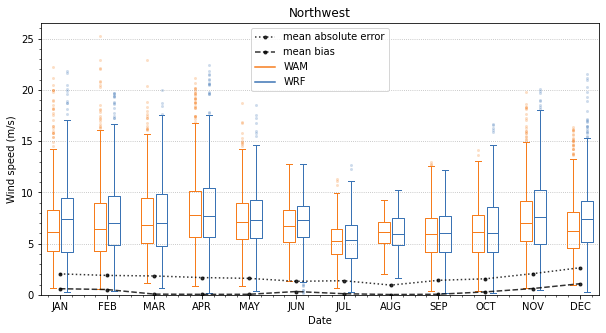

In [12]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    plt.setp(bp['fliers'], alpha=0.25, markeredgewidth=0, markersize=3, markerfacecolor=color)

meses_wam = []
for mes in range(1, 13) : meses_wam.append(WAM_80m[WAM_80m.index.month==mes].to_numpy(dtype=object))
meses_wrf = []
for mes in range(1, 13) : meses_wrf.append(WRF_80m[WRF_80m.index.month==mes].to_numpy(dtype=object))

pos=np.array(range(len(meses_wrf)),dtype=object)*2.0

plt.figure(figsize=(10,5))
wam_plt = plt.boxplot(meses_wam, positions=pos-0.3)
wrf_plt = plt.boxplot(meses_wrf, positions=pos+0.3)

set_box_color(wam_plt, '#F67C1C')
set_box_color(wrf_plt, '#3A73B4')

ticks = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
plt.xticks(range(0,len(ticks)*2,2), ticks)

plt.xlabel('Date')
plt.ylabel('Wind speed (m/s)')
plt.title(title)

#Monthly mean absolute error
mae_wam = []
for mes in range(0, 12) : mae_wam.append(sklearn.metrics.mean_absolute_error(meses_wam[mes],meses_wrf[mes]))
plt.plot(pos,mae_wam,'.:',c='black',label='mean absolute error',alpha=0.8)

#Monthly mean bias
mbias_wam = []
for mes in range(0, 12) : mbias_wam.append(np.mean(meses_wrf[mes]-meses_wam[mes]))
plt.plot(pos,mbias_wam,'.--',c='black',label='mean bias',alpha=0.8)

#Create legend
plt.plot([], c='#F67C1C', label='WAM')
plt.plot([], c='#3A73B4', label='WRF')
plt.legend()
plt.minorticks_on()
plt.grid(axis='y', color='black', linestyle=':', which='major', alpha=0.3)
plt.ylim(bottom=-0)
#plt.savefig(plotdir+'box_plot_'+title+'.pdf',format='pdf',bbox_inches='tight')

### Scatterplots

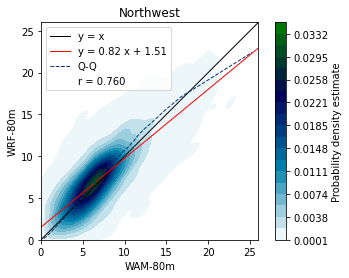

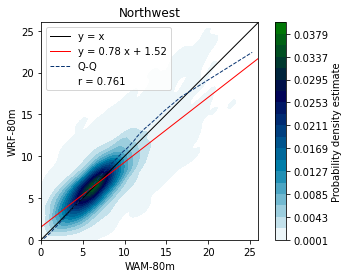

In [17]:
scat = gusi_utils.scatters(WAM_80m,WRF_80m,plotdir,title,'contour1','ocean_r')

### Diurnal Cycle

In [14]:
arr = np.zeros((12,24))
arr_wam = []
for mes in enumerate(arr):
	j = f'{mes[0]:02d}'
	hour = pd.to_timedelta(WAM_80m.loc['2018-'+str(int(j)+1)].index.hour, unit='H')
	means = WAM_80m.loc['2018-'+str(int(j)+1)].groupby(hour).mean().to_numpy()
	arr_wam.append(means)
arr_wam = np.stack(arr_wam)

In [15]:
arr = np.zeros((12,24))
arr_wrf = []
for mes in enumerate(arr):
	j = f'{mes[0]:02d}'
	hour = pd.to_timedelta(WRF_80m.loc['2018-'+str(int(j)+1)].index.hour, unit='H')
	means = WRF_80m.loc['2018-'+str(int(j)+1)].groupby(hour).mean().to_numpy()
	arr_wrf.append(means)
arr_wrf = np.stack(arr_wrf)

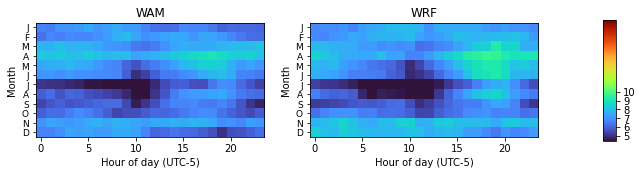

In [16]:
minv = 4.4#min(np.min(arr_wam), np.min(arr_wrf))
maxv = 18.2#max(np.max(arr_wam), np.max(arr_wrf))
#Rumorosa: 2.4, Ojuelos: 3.1, San Fernando:3.7, Cd Cuauhtemoc:1.7, Tepexi:1.6, Certe:4.4, Merida:3.2
#Rumorosa: 8.9, Ojuelos: 9.4, San Fernando:10.8, Cd Cuauhtemoc:8.9, Tepexi:10.2, Certe:18.2, Merida:8.9
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))

ax1 = plt.subplot(121)
im1 = ax1.imshow(arr_wam, cmap='turbo', vmin=minv, vmax=maxv, interpolation='Nearest')
ax1.set_xlabel('Hour of day (UTC-5)')
ax1.set_ylabel('Month')
ax1.set_yticks([0,1,2,3,4,5,6,7,8,9,10,11])
ax1.set_yticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax1.tick_params(axis='y', labelsize=9)
ax1.set_title('WAM')

ax2 = plt.subplot(122, sharey=ax1)
im2 = ax2.imshow(arr_wrf, cmap='turbo', vmin=minv, vmax=maxv, interpolation=None)
ax2.set_xlabel('Hour of day (UTC-5)')
ax2.set_ylabel('Month')
ax2.set_yticks([0,1,2,3,4,5,6,7,8,9,10,11])
ax2.set_yticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax2.tick_params(axis='y', labelsize=9)
ax2.set_title('WRF')

cbar_ax = fig.add_axes([1, 0.29, 0.02, 0.42])
cbar = fig.colorbar(im1, cax=cbar_ax, ticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
#cbar = fig.colorbar(im1, cax=cbar_ax, ticks=[5.0, 7.5, 10.0, 12.5, 15.0, 17.5])#Certe
cbar.ax.locator_params(nbins=10)

#plt.savefig(plotdir+'diurnal_'+title+'.pdf',format='pdf',bbox_inches='tight')